作业5

1、实现ransac算法

2、基于Hough变换的直线检测算法

1、编程实现斑点检测算法

In [3]:
import cv2
import numpy as np
import random


def compute_fundamental(x1, x2):
    n = x1.shape[1]
    if x2.shape[1] != n:
        raise ValueError("Number of points don't match.")

    # build matrix for equations
    A = np.zeros((n, 9))
    for i in range(n):
        A[i] = [x1[0, i] * x2[0, i], x1[0, i] * x2[1, i], x1[0, i] * x2[2, i],
                x1[1, i] * x2[0, i], x1[1, i] * x2[1, i], x1[1, i] * x2[2, i],
                x1[2, i] * x2[0, i], x1[2, i] * x2[1, i], x1[2, i] * x2[2, i]]

    # compute linear least square solution
    U, S, V = np.linalg.svd(A)
    F = V[-1].reshape(3, 3)

    # constrain F
    # make rank 2 by zeroing out last singular value
    U, S, V = np.linalg.svd(F)
    S[2] = 0
    F = np.dot(U, np.dot(np.diag(S), V))

    return F / F[2, 2]


def compute_fundamental_normalized(x1, x2):
    """    Computes the fundamental matrix from corresponding points
        (x1,x2 3*n arrays) using the normalized 8 point algorithm. """

    n = x1.shape[1]
    if x2.shape[1] != n:
        raise ValueError("Number of points don't match.")

    # normalize image coordinates
    x1 = x1 / x1[2]
    mean_1 = np.mean(x1[:2], axis=1)
    S1 = np.sqrt(2) / np.std(x1[:2])
    T1 = np.array([[S1, 0, -S1 * mean_1[0]], [0, S1, -S1 * mean_1[1]], [0, 0, 1]])
    x1 = np.dot(T1, x1)

    x2 = x2 / x2[2]
    mean_2 = np.mean(x2[:2], axis=1)
    S2 = np.sqrt(2) / np.std(x2[:2])
    T2 = np.array([[S2, 0, -S2 * mean_2[0]], [0, S2, -S2 * mean_2[1]], [0, 0, 1]])
    x2 = np.dot(T2, x2)

    # compute F with the normalized coordinates
    F = compute_fundamental(x1, x2)
    # print (F)
    # reverse normalization
    F = np.dot(T1.T, np.dot(F, T2))

    return F / F[2, 2]


def randSeed(good, num=8):
    """
    :param good: 初始的匹配点对
    :param num: 选择随机选取的点对数量
    :return: 8个点对list
    """
    eight_point = random.sample(good, num)
    return eight_point


def PointCoordinates(eight_points, keypoints1, keypoints2):
    """
    :param eight_points: 随机八点
    :param keypoints1: 点坐标
    :param keypoints2: 点坐标
    :return:8个点
    """
    x1 = []
    x2 = []
    tuple_dim = (1.,)
    for i in eight_points:
        tuple_x1 = keypoints1[i[0].queryIdx].pt + tuple_dim
        tuple_x2 = keypoints2[i[0].trainIdx].pt + tuple_dim
        x1.append(tuple_x1)
        x2.append(tuple_x2)
    return np.array(x1, dtype=float), np.array(x2, dtype=float)


def ransac(good, keypoints1, keypoints2, confidence, iter_num):
    print("ransac is running")
    Max_num = 0
    inlier_points = []
    for i in range(iter_num):
        eight_points = randSeed(good)
        x1, x2 = PointCoordinates(eight_points, keypoints1, keypoints2)
        F = compute_fundamental_normalized(x1.T, x2.T)
        num, ransac_good = inlier(F, good, keypoints1, keypoints2, confidence)
        if num > Max_num:
            Max_num = num
            inlier_points = ransac_good

    H = None
    if len(good) > 4:
        ptsR = np.float32(
            [keypoints2[m.trainIdx].pt for [m] in good]).reshape(-1, 1, 2)
        ptsL = np.float32(
            [keypoints1[m.queryIdx].pt for [m] in good]).reshape(-1, 1, 2)
        ransacReprojThreshold = 4
        H, status = cv2.findHomography(
            ptsR, ptsL, cv2.RANSAC, ransacReprojThreshold)

    # H = computeHomography(inlier_points, keypoints1, keypoints2)
    return Max_num, H, inlier_points


def computeReprojError(x1, x2, F):
    """
    计算投影误差
    """
    ww = 1.0 / (F[2, 0] * x1[0] + F[2, 1] * x1[1] + F[2, 2])
    dx = (F[0, 0] * x1[0] + F[0, 1] * x1[1] + F[0, 2]) * ww - x2[0]
    dy = (F[1, 0] * x1[0] + F[1, 1] * x1[1] + F[1, 2]) * ww - x2[1]
    return dx * dx + dy * dy


def inlier(F, good, keypoints1, keypoints2, confidence):
    num = 0
    ransac_good = []
    x1, x2 = PointCoordinates(good, keypoints1, keypoints2)
    for i in range(len(x2)):
        line = F.dot(x1[i].T)
        # 在对极几何中极线表达式为[A B C],Ax+By+C=0,  方向向量可以表示为[-B,A]
        line_v = np.array([-line[1], line[0]])
        err = h = np.linalg.norm(np.cross(x2[i, :2], line_v) / np.linalg.norm(line_v))
        # err = computeReprojError(x1[i], x2[i], F)
        if abs(err) < confidence:
            ransac_good.append(good[i])
            num += 1
    return num, ransac_good

def computeHomography(matches, kp1, kp2):
    point_map = np.array([
        [kp1[match.queryIdx].pt[0],
         kp1[match.queryIdx].pt[1],
         kp2[match.trainIdx].pt[0],
         kp2[match.trainIdx].pt[1]] for [match] in matches
    ])
    pairs = [point_map[i] for i in np.random.choice(len(point_map), 4)]
    A = []
    for x1, y1, x2, y2 in pairs:
        A.append([x1, y1, 1, 0, 0, 0, -x2 * x1, -x2 * y1, -x2])
        A.append([0, 0, 0, x1, y1, 1, -y2 * x1, -y2 * y1, -y2])
    A = np.array(A)

    # Singular Value Decomposition (SVD)
    U, S, V = np.linalg.svd(A)

    # V has shape (9, 9) for any number of input pairs. V[-1] is the eigenvector
    # of (A^T)A with the smalles eigenvalue. Reshape into 3x3 matrix.
    H = np.reshape(V[-1], (3, 3))

    # Normalization
    H = (1 / H.item(8)) * H
    return H


2、基于Hough变换的直线检测算法

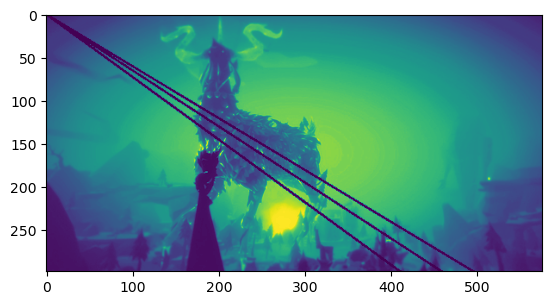

In [4]:
import numpy as np
import math
import cv2
from  matplotlib import pyplot as plt

def hough_line_detection(image, threshold):
    # 图像尺寸
    height, width = image.shape[:2]
    
    # Hough空间参数范围
    max_rho = int(math.hypot(height, width))
    max_theta = 180
    
    # 累加器（Hough空间）
    accumulator = np.zeros((max_rho, max_theta))
    
    # 非零像素点的坐标
    points = np.nonzero(image)
    y_coordinates, x_coordinates = points[0], points[1]
    
    # 遍历所有非零像素点
    for i in range(len(x_coordinates)):
        x = x_coordinates[i]
        y = y_coordinates[i]
        
        # 在Hough空间中遍历所有可能的rho和theta
        for theta in range(max_theta):
            rho = int(x * math.cos(math.radians(theta)) + y * math.sin(math.radians(theta)))
            accumulator[rho, theta] += 1
    
    # 选取满足阈值条件的直线
    lines = []
    for rho in range(max_rho):
        for theta in range(max_theta):
            if accumulator[rho, theta] > threshold:
                lines.append((rho, theta))
    
    return lines

# 读取图像
image = cv2.imread('image.bmp', cv2.IMREAD_GRAYSCALE)

# Canny边缘检测
edges = cv2.Canny(image, 50, 150)

# 应用Hough变换进行直线检测
lines = hough_line_detection(edges, threshold=100)

# 在图像上绘制检测到的直线
for line in lines:
    rho, theta = line
    a = np.cos(math.radians(theta))
    b = np.sin(math.radians(theta))
    x0 = a * rho
    y0 = b * rho
    x1 = int(x0 + 1000 * (-b))
    y1 = int(y0 + 1000 * (a))
    x2 = int(x0 - 1000 * (-b))
    y2 = int(y0 - 1000 * (a))
    cv2.line(image, (x1, y1), (x2, y2), (0, 0, 255), 2)

# 显示结果
plt.imshow(image)
plt.show()